# Gigs Senior Data Analyst Challenge

Welcome to the Gigs data analyst take-home challenge! This notebook will help you get started with analyzing our connectivity usage data.

## About the Data

You'll be working with three main datasets:
- **Usage Data**: Detailed usage per subscription period (~100K+ records)
- **Plan Events**: Plan configuration and pricing history
- **Projects**: Project metadata

## Setup Instructions

Run the cells below to set up your environment and load the data into DuckDB.

In [5]:
# Import required libraries
import duckdb
import pandas as pd
from datetime import datetime, timedelta
import pandas as pd
import jupyter_black

jupyter_black.load()


In [6]:
# lets simply load this into pandas  and get on with out lives
def read_data():

    paths = [
        "data/usage_by_subscription_period.csv",
        "data/plan_change_events.csv",
        "data/projects.csv",
    ]
    return {
        path.split("/")[-1].replace(".csv", ""): pd.read_csv(path) for path in paths
    }


data_frames = read_data()

# How much data does a subscription typically consume?
## Metric
* Usage per day
* Usage per limit
## Calculations
* get the allowances and features such as 
    * price_currency
    * plan name
    * data_allowance_mb
    * is_unlimited_data
    * validity_unit
    * _valid_from_valid_to
## from projects get
* device_type
* project_type





In [7]:
def parse_plan_events(plan_events_df):
    # parse the date columns
    plan_events_df["_valid_from"] = pd.to_datetime(
        plan_events_df["_valid_from"].fillna("2099-12-31"), format="mixed"
    )
    plan_events_df["_valid_to"] = pd.to_datetime(
        plan_events_df["_valid_to"].fillna("2099-12-31"), format="mixed"
    )
    plan_events_df["plan_created_at"] = pd.to_datetime(
        plan_events_df["plan_created_at"].fillna("2099-12-31"), format="mixed"
    )
    return plan_events_df



#
# plan_events_df=data_frames['plan_change_events']
# # parse the date columns
# plan_events_df['_valid_from']=pd.to_datetime(plan_events_df['_valid_from'].fillna('2099-12-31'),format='mixed')
# plan_events_df['_valid_to']=pd.to_datetime(plan_events_df['_valid_to'].fillna('2099-12-31'),format='mixed')
# plan_events_df['plan_created_at']=pd.to_datetime(plan_events_df['plan_created_at'].fillna('2099-12-31'),format='mixed')
#
# plan_events_df.groupby(['plan_name','plan_id']).agg({'validity_unit':['min','max','count'],'validity_value':['min','max','count']})

In [17]:
def combine_data(data_frames):
    plan_events_df = parse_plan_events(data_frames["plan_change_events"])
    usage_df = data_frames["usage_by_subscription_period"]
    usage_df["subscription_period_start"] = pd.to_datetime(
        usage_df["subscription_period_start"], format="mixed"
    )
    usage_df["subscription_period_end"] = pd.to_datetime(
        usage_df["subscription_period_end"], format="mixed"
    )
    usage_df["reporting_date"] = pd.to_datetime(
        usage_df["reporting_date"], format="mixed"
    )
    usage_df_joined = usage_df.merge(
        plan_events_df,
        left_on=["plan_id", "project_id__hashed"],
        right_on=["plan_id", "project_id__hashed"],
    )
    # valid_to must be coalesced to a future date if null
    usage_df_joined_filtered = usage_df_joined[
        (usage_df_joined["subscription_period_start"] >= usage_df_joined["_valid_from"])
        & (
            usage_df_joined["subscription_period_start"]
            <= usage_df_joined["_valid_to"].fillna(pd.Timestamp("2099-12-31"))
        )
    ]

    usage_df_joined_filtered_w_projects = usage_df_joined_filtered.merge(
        data_frames["projects"],
        left_on="project_id__hashed",
        right_on="project_id__hashed",
        how="left",
    )
    print(
        usage_df_joined_filtered.shape,
        usage_df_joined.shape,
        usage_df.shape,
        usage_df_joined_filtered_w_projects.shape,
    )

    return usage_df_joined_filtered_w_projects


# need to join usage with plan events on plan_id and filter based on _valid_from and _valid_to
analytics_df_proto = combine_data(data_frames)
# so join based on an exact match with the plain_id key and a >= _valid_from and <= _valid_to  in events on the subscription_period_start column in usage

(53542, 29) (425611, 29) (53565, 11) (53542, 32)


In [18]:
# Lets look at some basic stats
analytics_df_proto.groupby(["plan_name", "plan_id"]).agg(
    {
        "plan_id": ["count"],
        "data_allowance_mb": ["first", "min", "max"],
        "is_unlimited_data": ["first", "min", "max"],
        "validity_unit": ["first", "min", "max"],
        "validity_value": ["first", "min", "max"],
    }
).reset_index()

plan_name                           plan_id         \
                                                           count   
0                   5GB  pln_3547586bf1a44e88d28081a6a456    129   
1                   5GB  pln_e4a7120c0bc0b1a583d931cf5815      6   
2              5GB Plan  pln_430cdc0fcb816e47e1ce1fc05b0c      2   
3            Basic Plan  pln_588c59e59103c836fb97c0352a47    460   
4             Easy Plan  pln_0a3b55b9abb575b023c07e617b49  44619   
5    No Allowances Plan  pln_c2e73083cdcd7349ed576eea5f06     68   
6             Plus Plan  pln_af7b4a30086929d37e7f4eb3daed   2723   
7       Ultra Unlimited  pln_b109c69e95246b6d535b9cc9174f    510   
8       Ultra Unlimited  pln_be484393f3f4236b0d97a8e08cc6    104   
9   Unlimited Data Plan  pln_1d3f49d61a672755efc1865c4d9a   3924   
10       Unlimited Plan  pln_a77a368011e31330c4ce88614272    517   
11       Unlimited Plan  pln_c5b25fc1ad1cfcaf90a87b7e086a    480   

   data_allowance_mb                 is_unlimited_data                \
               first     min     max             first    min    max   
0             5000.0  5000.0  5000.0             False  False  False   
1             5000.0  5000.0  5000.0             False  False  False   
2             5000.0  5000.0  5000.0             False  False  False   
3             5000.0  5000.0  5000.0             False  False  False   
4             1000.0  1000.0  1000.0             False  False  False   
5                0.0     0.0     0.0             False  False  False   
6             5000.0  5000.0  5000.0             False  False  False   
7                NaN     NaN     NaN              True   True   True   
8                NaN     NaN     NaN              True   True   True   
9                NaN     NaN     NaN              True   True   True   
10               NaN     NaN     NaN              True   True   True   
11               NaN     NaN     NaN              True   True   True   

   validity_unit               validity_value          
           first    min    max          first min max  
0            day    day    day             30  30  30  
1            day    day    day             30  30  30  
2            day    day    day             30  30  30  
3            day    day    day             30  30  30  
4          month  month  month              1   1   1  
5            day    day    day             30  30  30  
6          month  month  month              1   1   1  
7            day    day    day             30  30  30  
8            day    day    day             30  30  30  
9          month  month  month              1   1   1  
10           day    day    day             30  30  30  
11           day    day    day             30  30  30

In [19]:
# onwards!
# lets see data usage per day for each plan and each month
import matplotlib.pyplot as plt


def add_analytics_features(analysis_df_proto):
    return (
        analysis_df_proto.sort_values(["subscription_id", "reporting_date"])
        .assign(
            subscription_period_start=pd.to_datetime(
                analysis_df_proto["subscription_period_start"]
            ),
            subscription_period_end=pd.to_datetime(
                analysis_df_proto["subscription_period_end"]
            ),
            reporting_date=pd.to_datetime(analysis_df_proto["reporting_date"]),
            subscription_overall_start_date=lambda df: df[
                ["subscription_period_start", "subscription_id"]
            ]
            .groupby("subscription_id")
            .cummin(),
            subscription_overall_end_date=lambda df: df[
                ["subscription_period_end", "subscription_id"]
            ]
            .groupby("subscription_id")["subscription_period_end"]
            .transform("max"),
            cumsum_cumulative_data_usage_megabyte=lambda df: df[
                ["cumulative_data_usage_megabyte", "subscription_id"]
            ]
            .groupby("subscription_id")
            .cumsum(),
            overall_cumulative_data_usage_megabyte=lambda df: df[
                ["cumulative_data_usage_megabyte", "subscription_id"]
            ]
            .groupby("subscription_id")["cumulative_data_usage_megabyte"]
            .transform("sum"),
            pct_used_of_lifetime=lambda df: df["cumsum_cumulative_data_usage_megabyte"]
            / df["overall_cumulative_data_usage_megabyte"],
            pct_used_this_period_from_lifetime=lambda df: df[
                "cumulative_data_usage_megabyte"
            ]
            / df["overall_cumulative_data_usage_megabyte"],
            subscription_pediod_nr=lambda df: df[
                ["subscription_period_start", "subscription_id"]
            ]
            .groupby("subscription_id")
            .cumcount()
            + 1,
            subscription_days=lambda x: (
                x["reporting_date"] - x["subscription_overall_start_date"]
            ).dt.days
            + 1,
            max_subscription_days=lambda x: (
                x["subscription_overall_end_date"]
                - x["subscription_overall_start_date"]
            ).dt.days
            + 1,
            lifetime_pct=lambda df: (
                df["subscription_days"] / df["max_subscription_days"]
            ).round(1),
            usage_per_day=lambda x: x["cumulative_data_usage_megabyte"]
            / x["subscription_days"],
            usage_per_limit=lambda x: x["cumulative_data_usage_megabyte"]
            / x["data_allowance_mb"],
            first_data_usage=lambda df: df[
                ["cumulative_data_usage_megabyte", "subscription_id"]
            ]
            .groupby("subscription_id")["cumulative_data_usage_megabyte"]
            .transform("first"),
            next_billing_date=lambda df: df[
                ["subscription_period_end", "subscription_id"]
            ]
            .groupby("subscription_id")
            .shift(-1),
            is_churn=lambda df: df["next_billing_date"].isna(),
            data_usage_growth_proto=lambda df: (
                (df["cumulative_data_usage_megabyte"].div(df["first_data_usage"])) - 1
            ).fillna(0),
            data_usage_growth=lambda df: df["data_usage_growth_proto"].clip(
                lower=0, upper=3
            ),
            data_allowance_mb=lambda df: df["data_allowance_mb"].fillna(10000),
        )
        .assign(
            months_since_subscription_start=lambda x: (
                x["reporting_date"] - x["subscription_period_start"]
            ).dt.days
        )
    )


analysis_df = add_analytics_features(analytics_df_proto)
analysis_df.shape

(53542, 50)

# Discussion

## How much data does a subscription typically consume?
There are many ways to go about this! A longer subscription will consume more, and this depends on many other things, such as plan data allowance, and the lifecylce of the users. Lets take a look at both monthly consumption as well as total consumption over the lifetime of a subscription!


/tmp/ipykernel_72916/4051498049.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df_filtered["data_allowance_mb"] = analysis_df_filtered[


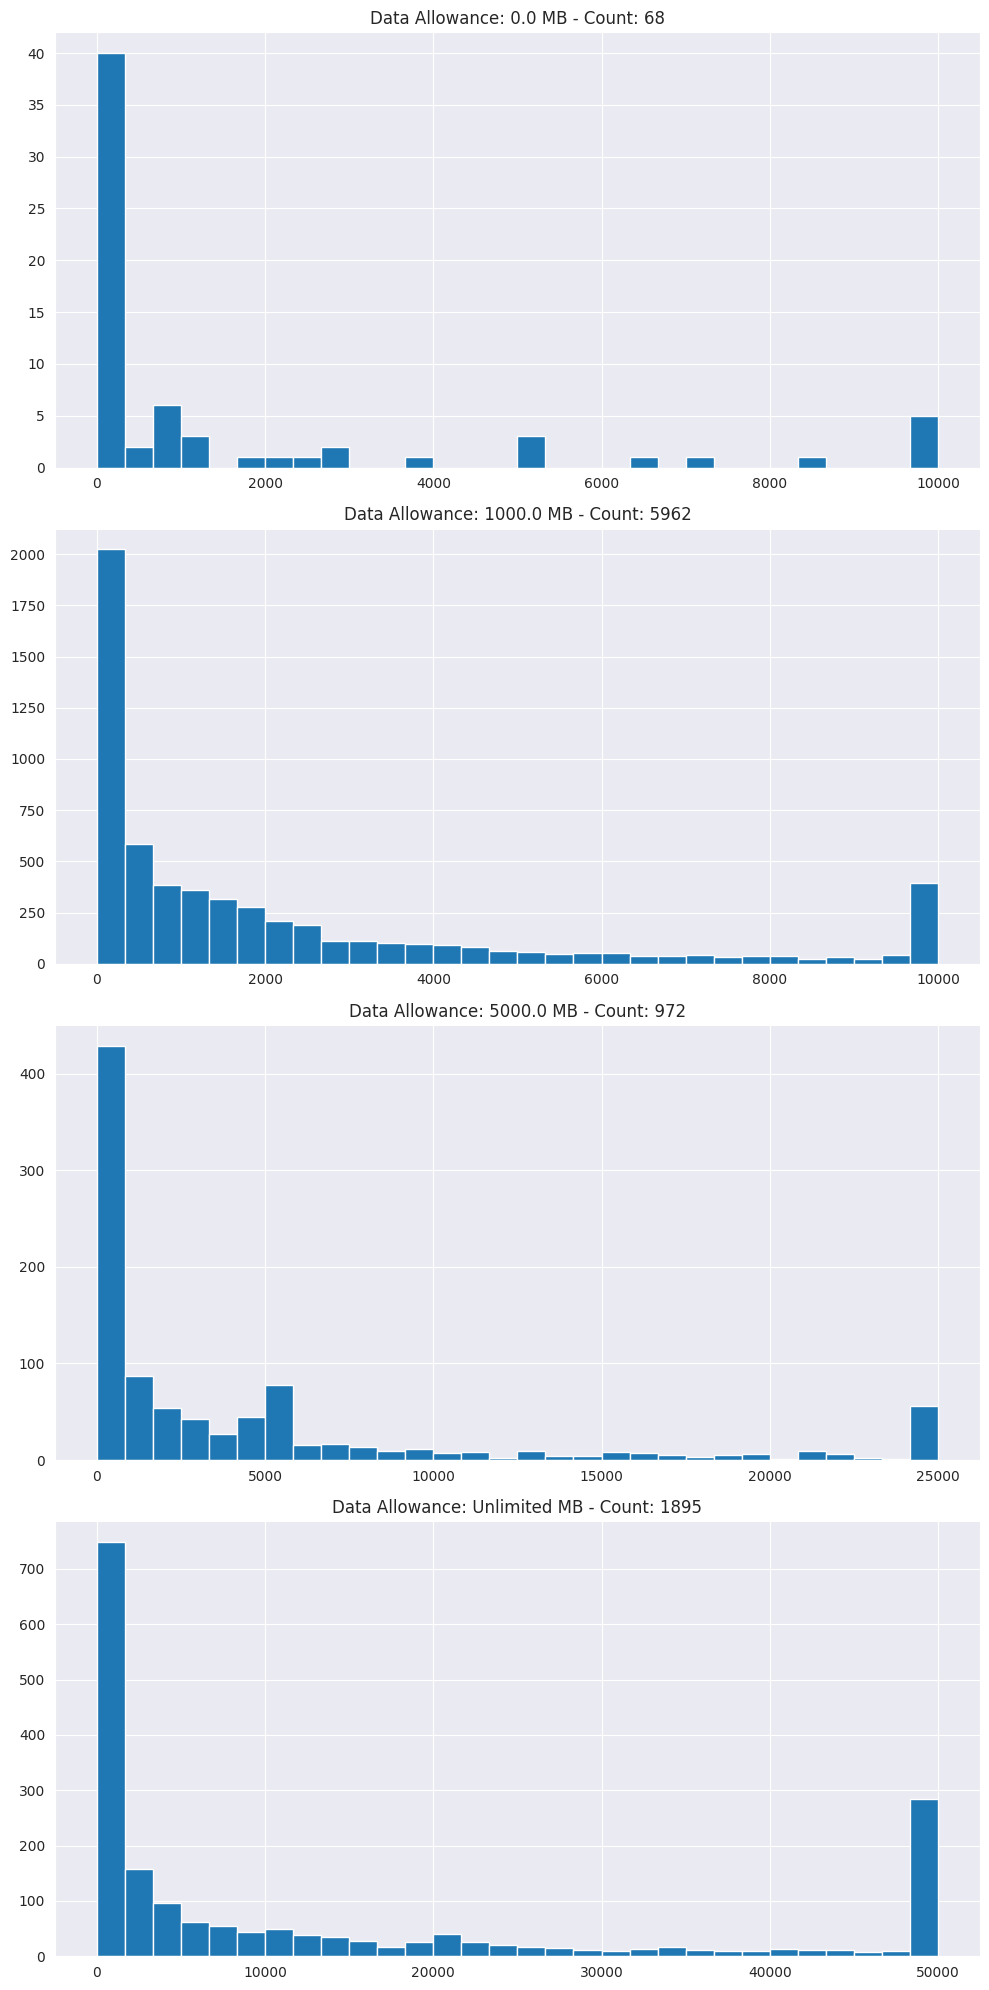

In [36]:
plot_df = (
    analysis_df.groupby(
        [
            "subscription_id",
            "plan_name",
            "validity_unit",
            "validity_value",
            "data_allowance_mb",
        ]
    )
    .agg({"subscription_days": "max", "cumulative_data_usage_megabyte": "sum"})
    .sort_values("subscription_days", ascending=False)
    .reset_index()
)

# make a histogram of data usage per data allowance category
# great so they are indeed all monthly plans except for the no allowances plan
drop_plan_ids = ["pln_e4a7120c0bc0b1a583d931cf5815", "pln_430cdc0fcb816e47e1ce1fc05b0c"]
# less than 10 subs, these must be tests
analysis_df_filtered = analysis_df.loc[~analysis_df["plan_id"].isin(drop_plan_ids)]
analysis_df_filtered["data_allowance_mb"] = analysis_df_filtered[
    "data_allowance_mb"
].fillna(10000)

# 4 histograms of usage_per_day by data allowance buckets
allowance_values = plot_df["data_allowance_mb"].unique()
allowance_values.sort()
fig, axs = plt.subplots(
    len(allowance_values), 1, figsize=(10, 5 * len(allowance_values))
)
for i, allowance in enumerate(allowance_values):
    ax = axs[i]
    upper_limit = max(10000, allowance * 5)
    allowance_text = "Unlimited" if allowance >= 10000 else str(allowance)
    data = plot_df.loc[
        plot_df["data_allowance_mb"] == allowance, "cumulative_data_usage_megabyte"
    ].clip(upper=upper_limit)
    ax.hist(data, bins=30)
    ax.set_title(f"Data Allowance: {allowance_text} MB - Count: {len(data)}")
plt.tight_layout()

In [37]:
# long tailed distribution, median is better than average to represent typical usage
plot_df.groupby("data_allowance_mb").agg(
    {"cumulative_data_usage_megabyte": ["count", "mean", "median"]}
).sort_index()

cumulative_data_usage_megabyte                           
                                           count          mean       median
data_allowance_mb                                                          
0.0                                           68   3766.828288   198.388736
1000.0                                      5962   2738.681037   990.048768
5000.0                                       972   5790.105802  1342.008294
10000.0                                     1895  28203.449482  4164.427958

In [40]:
plot_df.shape

(53541, 8)

/tmp/ipykernel_72916/3218138098.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  analysis_df_filtered["data_allowance_mb"] = analysis_df_filtered[


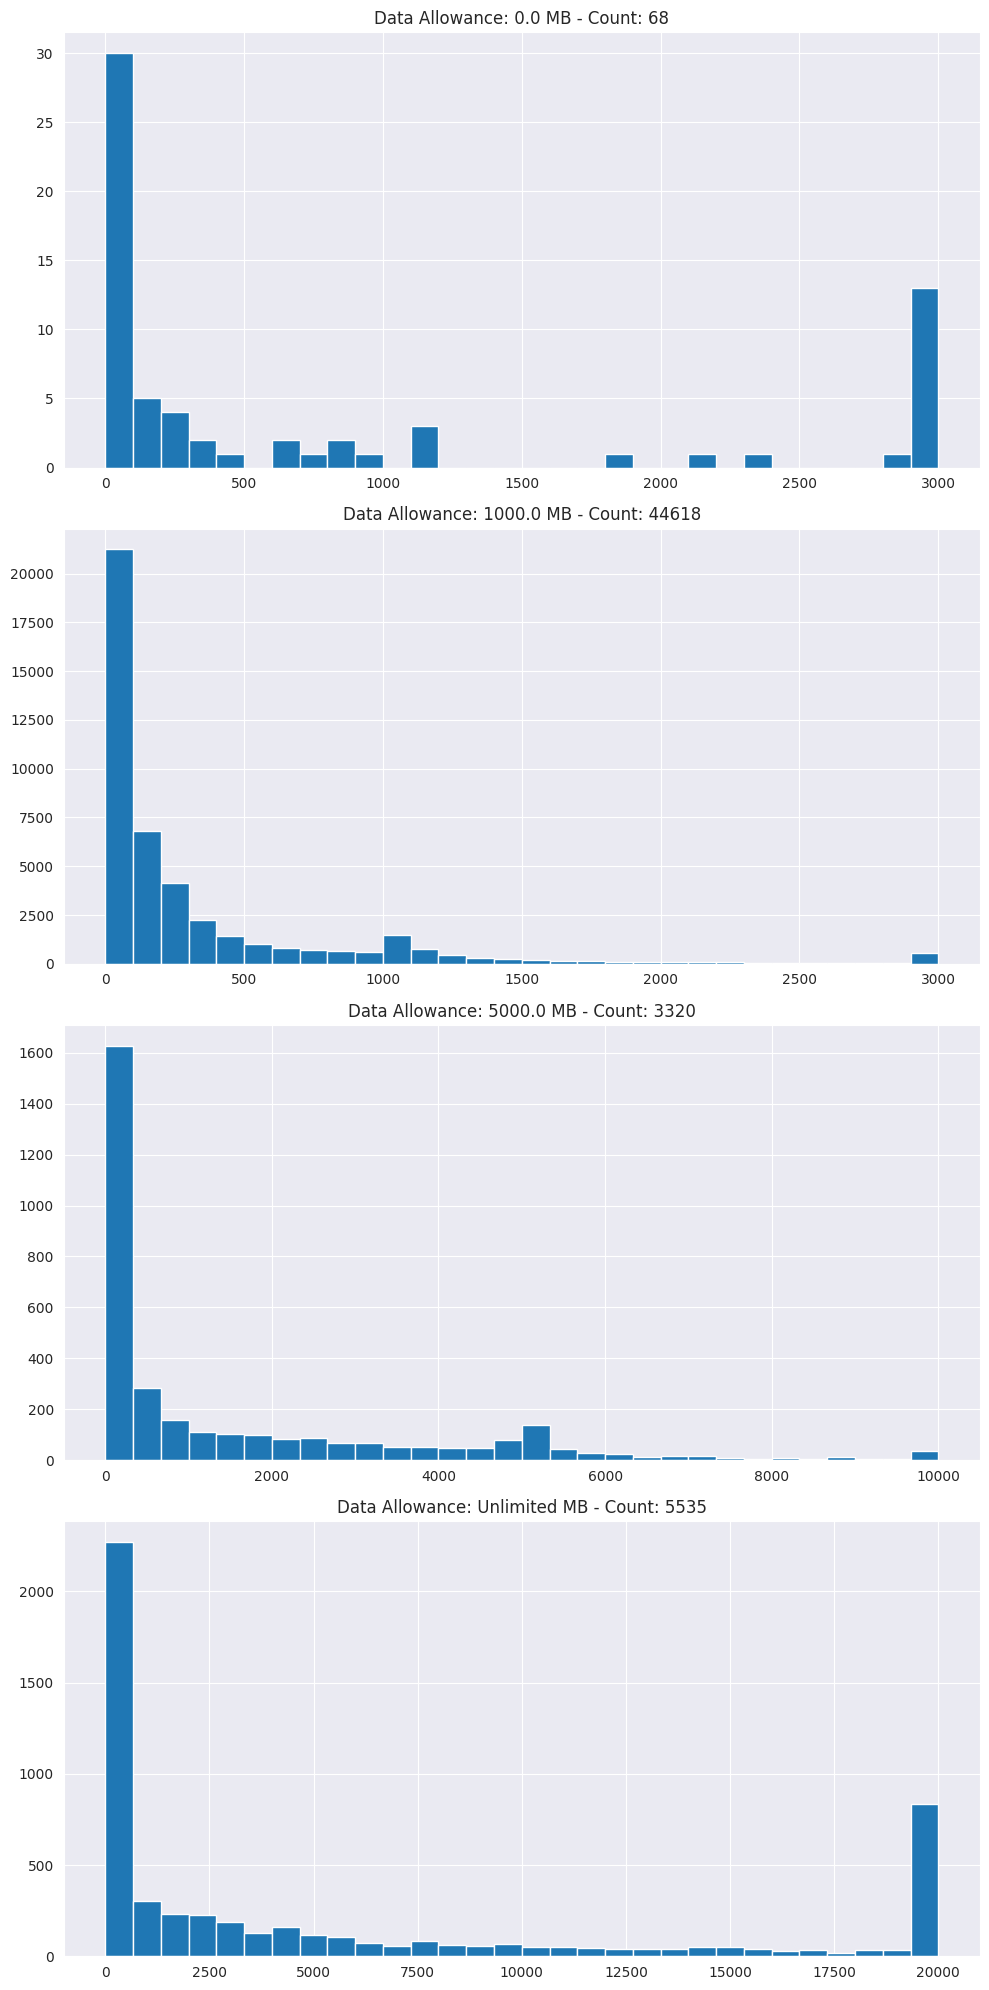

In [39]:
# a different way to represent this is looking at it every month

plot_df = (
    analysis_df.groupby(
        [
            "subscription_id",
            "plan_name",
            "reporting_date",
            "validity_unit",
            "validity_value",
            "data_allowance_mb",
        ]
    )
    .agg({"subscription_days": "max", "cumulative_data_usage_megabyte": "sum"})
    .sort_values("subscription_days", ascending=False)
    .reset_index()
)

# make a histogram of data usage per data allowance category
# great so they are indeed all monthly plans except for the no allowances plan
drop_plan_ids = ["pln_e4a7120c0bc0b1a583d931cf5815", "pln_430cdc0fcb816e47e1ce1fc05b0c"]
# less than 10 subs, these must be tests
analysis_df_filtered = analysis_df.loc[~analysis_df["plan_id"].isin(drop_plan_ids)]
analysis_df_filtered["data_allowance_mb"] = analysis_df_filtered[
    "data_allowance_mb"
].fillna(10000)

# 4 histograms of usage_per_day by data allowance buckets
allowance_values = plot_df["data_allowance_mb"].unique()
allowance_values.sort()
fig, axs = plt.subplots(
    len(allowance_values), 1, figsize=(10, 5 * len(allowance_values))
)
for i, allowance in enumerate(allowance_values):
    ax = axs[i]
    upper_limit = max(3000, allowance * 2)
    allowance_text = "Unlimited" if allowance >= 10000 else str(allowance)
    data = plot_df.loc[
        plot_df["data_allowance_mb"] == allowance, "cumulative_data_usage_megabyte"
    ].clip(upper=upper_limit)
    ax.hist(data, bins=30)
    ax.set_title(f"Data Allowance: {allowance_text} MB - Count: {len(data)}")
plt.tight_layout()

In [35]:
# summary stats of this
plot_df.groupby("data_allowance_mb").agg(
    {"cumulative_data_usage_megabyte": ["count", "mean", "median", "max"]}
).sort_index()
# summarize in a bar chart on the median

cumulative_data_usage_megabyte                            \
                                           count         mean       median   
data_allowance_mb                                                            
0.0                                           68  3766.828288   198.388736   
1000.0                                     44618   365.951328   114.100736   
5000.0                                      3320  1695.175554   361.266688   
10000.0                                     5535  9655.923535  1876.326400   

                                  
                             max  
data_allowance_mb                 
0.0                 80762.446848  
1000.0             110371.431424  
5000.0             250785.320960  
10000.0            282946.536448

All in all, a typical subscription consumes ~150-300 MB per month and ~ 1GB during their lifetime, depending on the data allowance of the plan.

# Consumption over lifecycle
Lets compare the evolution of data consumption over the progression of a subscription.

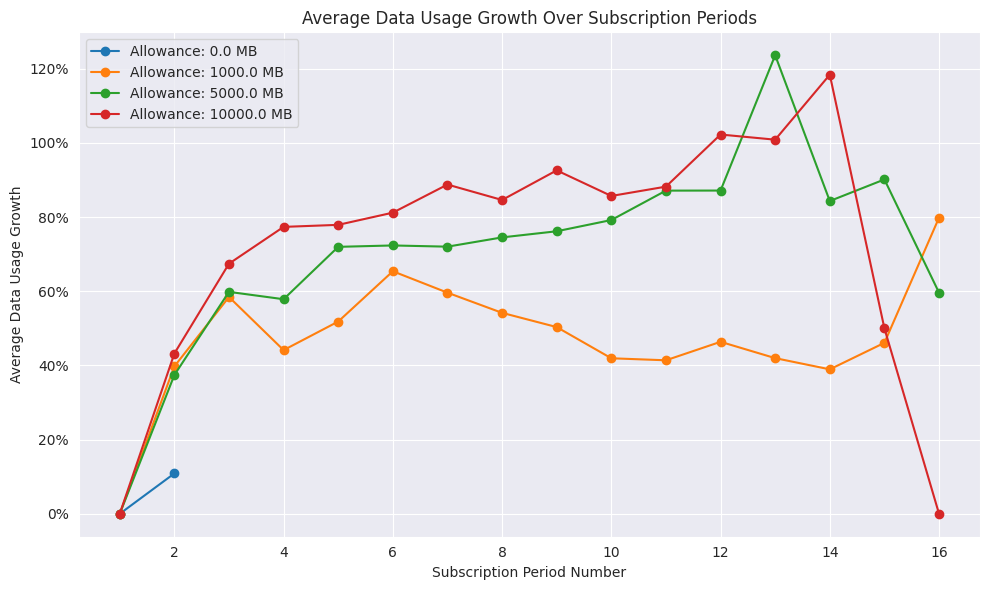

In [43]:
plot_df = (
    analysis_df.groupby(["data_allowance_mb", "subscription_pediod_nr"])
    .agg({"data_usage_growth": "mean"})
    .reset_index()
)
# a line chart of this per allolwance
# LINE CHART
fig, ax = plt.subplots(figsize=(10, 6))
for allowance in plot_df["data_allowance_mb"].unique():
    data = plot_df.loc[plot_df["data_allowance_mb"] == allowance]
    ax.plot(
        data["subscription_pediod_nr"],
        data["data_usage_growth"],
        "o-",
        label=f"Allowance: {allowance} MB",
    )
    # format y axis as percentage
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))
ax.set_title("Average Data Usage Growth Over Subscription Periods")
ax.set_xlabel("Subscription Period Number")
ax.set_ylabel("Average Data Usage Growth")
# y axis is percentage growth from first data usage
# format y axis

ax.legend()
plt.tight_layout()

It takes about 3-4 months for data usage to stabilize. It keeps growing with the 5 GB plan and the Unlimited plans, but this is most likely survivor bias.

# Retention Patterns
Look at how many people started a subscription per project, then look at how many are still subscribers after n billing periods!

In [46]:
# figure out the launch time of each project from the usage data
project_launch_dates = (
    analysis_df.groupby(["organization_name", "project_type"])
    .agg({"reporting_date": "min"})
    .rename({"reporting_date": "project_launch_date"}, axis=1)
)
project_launch_dates
# lets see the retentionrate of each project
# lets see retention rate overall with the is_churned column
# lets see it from the events as well

,,project_launch_date
organization_name,project_type,
ACME Phone,Connect,2024-02-07
People Mobile,API,2025-04-19
SmartDevices Inc.,Connect,2025-03-11


In [47]:
# lets see the retentionrate of each project
# lets see retention rate overall with the is_churned column
retention_df = (
    analysis_df.groupby(["organization_name", "subscription_pediod_nr"])
    .agg({"is_churn": ["mean", "sum"], "subscription_id": "count"})
    .assign(
        starting_subs=lambda df: df.groupby("organization_name")[
            "subscription_id"
        ].transform("max"),
    )
    .reset_index()
)
retention_df.columns = [
    "organization_name",
    "subscription_pediod_nr",
    "monthly_churn_rate",
    "total_churns",
    "active_subscriptions",
    "starting_subscriptions",
]
retention_df["retention_rate"] = (
    retention_df["active_subscriptions"] / retention_df["starting_subscriptions"]
)

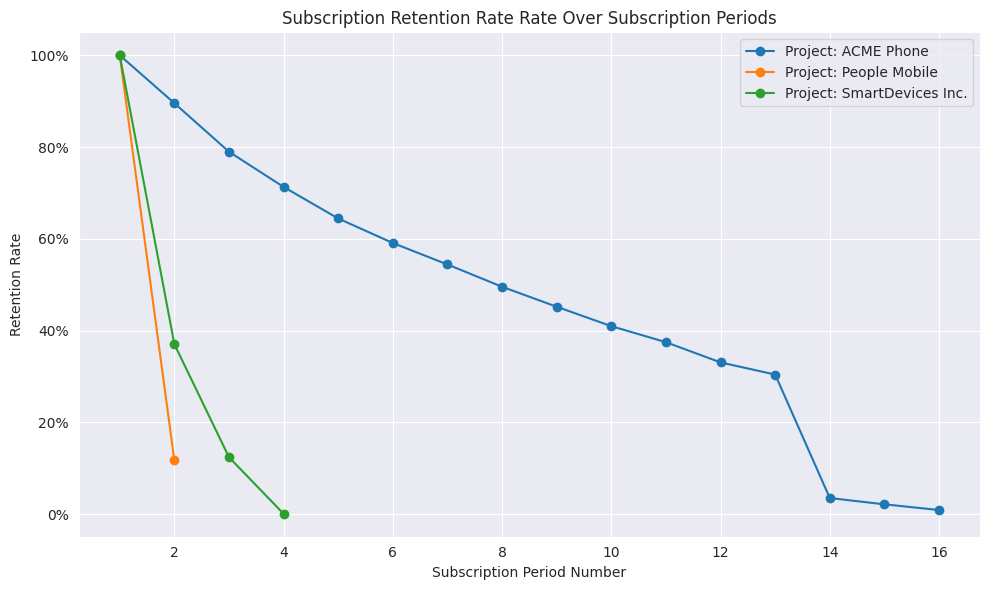

In [49]:
# plot these retention patterns on line charts
fig, ax = plt.subplots(figsize=(10, 6))
for project_id in retention_df["organization_name"].unique():
    data = retention_df.loc[retention_df["organization_name"] == project_id]
    ax.plot(
        data["subscription_pediod_nr"],
        data["retention_rate"],
        "o-",
        label=f"Project: {project_id}",
    )
    # y axis percent format
    ax.yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: "{:.0%}".format(y)))
ax.set_title("Subscription Retention Rate Rate Over Subscription Periods")
ax.set_xlabel("Subscription Period Number")
ax.set_ylabel("Retention Rate")

ax.legend()
plt.tight_layout()

It looks like the New Plan is losing subscribers faster than the other 2 plans after subscription.
